# Imports and Function Definitions

In [143]:
import pandas as pd
import numpy as np
from math import ceil, sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set()

import warnings
warnings.filterwarnings('ignore')
from polygon import RESTClient

import datetime as dt

In [2]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)
def ensemble_tree_feat_importance(m, df):
    feature_importances = np.mean([
    tree.feature_importances_ for tree in m.estimators_
                                    ], axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)
def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(15,20), legend=False)
def xgb_feat_importance(m, df):
    feature_importances = m.feature_importances_
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)

In [43]:
# A bunch of nonparametric regression models + some parametric baselines
def model_selection(ml):
    print(ml)
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3] #1e-5,1e-7
        grid['n_estimators'] = [10] #50,100,1000
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=25)
        grid = dict()
        grid['max_depth'] = [3,5,7,10]
        grid['n_estimators'] = [10,50,100,1000]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\

                        ).fit(X_train, y_train)
    elif ml == 'AB':
        model = AdaBoostRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-4,1e-2,1]
        grid['n_estimators'] = [10,50,100,1000]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = AdaBoostRegressor(
                    learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                        ).fit(X_train, y_train)
          
    elif ml == 'KR':
        model = KernelRidge()
        grid = dict()
        grid['alpha'] = [1e-2,1e-1,1,10,100]
        grid["kernel"] = ["poly","sigmoid","rbf","cosine"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KernelRidge(alpha=grid_result.best_params_["alpha"],
                                 kernel=grid_result.best_params_["kernel"]).fit(X_train, y_train)
    elif ml == 'R':
        model = Ridge()
        grid = dict()
        grid['alpha'] = [1e-2,1e-1,1,10,100]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = Ridge(alpha=grid_result.best_params_["alpha"]).fit(X_train, y_train)
        
    elif ml == "LA":
        model = Lasso()
        grid = dict()
        grid['alpha'] = [1e-2,1e-1,1,10,100]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = Lasso(alpha=grid_result.best_params_["alpha"]).fit(X_train, y_train)
        
        
    elif ml == "EN":
        model = ElasticNet()
        grid = dict()
        grid['alpha'] = [1e-2,1e-1,1,10,100]
        grid["l1_ratio"] = [0.1,0.5,0.7,0.9,0.95]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = ElasticNet(alpha=grid_result.best_params_["alpha"],
                                l1_ratio = grid_result.best_params_["l1_ratio"]).fit(X_train, y_train)
    
    elif ml == "NW":
        # Bandwidth is selected automatically
        model = KernelRegression()
        grid = dict()
        grid["gamma"] = [1e-2, 1e-1, 1, 10,100]
        grid['kernel'] = ["rbf","poly"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KernelRegression(gamma=grid_result.best_params_["gamma"],
                            kernel = grid_result.best_params_["kernel"]).fit(X_train, y_train)
        
    elif ml == "KN":
        model = KNeighborsRegressor()
        grid = dict()
        grid["n_neighbors"] = [5,10,40,100]
        grid['weights'] = ["uniform","distance"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KNeighborsRegressor(n_neighbors=grid_result.best_params_["n_neighbors"],
                            weights = grid_result.best_params_["weights"]).fit(X_train, y_train)
        
    print(model_best)
    y_pred = model_best.predict(X_test)
    print('MAE: ', mean_absolute_error(y_pred, y_test), 
          'MAE%: ', 100 * mean_absolute_error(y_pred, y_test)/np.mean(y_test), 
          '\nMSE: ', mean_squared_error(y_pred,y_test), 
          '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_test, y_pred)#, [X_train, X_test, y_train, y_test])

# Cleaning and Merging

In [3]:
client = RESTClient(api_key="18U85gkK04AWHrbE3oWvG9b3fF8JdlxQ")

In [4]:
vxx = client.get_aggs(ticker='VXX', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
spy = client.get_aggs(ticker='SPY', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
uso = client.get_aggs(ticker='USO', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)

In [5]:
poly_dict = {'vxx':vxx, 'spy':spy, 'uso':uso}

In [6]:
for data in poly_dict.keys():
    poly_dict[data] = pd.DataFrame(poly_dict[data])[['close', 'timestamp']]
    poly_dict[data] = poly_dict[data].rename(columns={'close':'Close', 'timestamp':'Local time'})
    poly_dict[data]['Local time'] = pd.to_datetime(poly_dict[data]['Local time'], unit='ms')

In [7]:
vxx = poly_dict['vxx']
spy = poly_dict['spy']
uso = poly_dict['uso']

In [8]:
fut = pd.read_csv('LIGHT.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
gas = pd.read_csv('GAS.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
btc = pd.read_csv('BTCUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
bond = pd.read_csv('USTBOND.TRUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')

In [9]:
data_dict = {'fut':fut, 'gas':gas, #'vxx':vxx, 'spy':spy, #'uso':uso, 
            'btc':btc, 'bond':bond}

## Datetime and indexing

In [309]:
# idx = pd.to_datetime(data_dict['fut']['Local time'])
# idx=idx.apply(lambda x: x.replace(tzinfo=None))

In [10]:
for data in data_dict.keys():
    if data in ['vxx', 'spy', 'uso']:
        data_dict[data] = data_dict[data].set_index(idx)
        data_dict[data] = data_dict[data].drop(['Open', 'High', 'Low', 'Volume', 'Local time'], axis=1)
    else:     
        ix = pd.to_datetime(data_dict[data]["Local time"].apply(lambda x: " ".join(x.split()[0:2])), format='%d.%m.%Y %H:%M:%S.%f')
        data_dict[data] = data_dict[data].set_index(ix)['Close']

## Merging

In [56]:
# df = pd.DataFrame(index=data_dict['vxx'].index)
df = pd.DataFrame(index=data_dict['fut'].index)
for data in data_dict.keys():
    df = pd.merge(df, data_dict[data], left_index=True, right_index=True, suffixes=['', '_'+data], how='left')
df = df.rename(columns={'Close':'Close_fut'})

## Cut to market hours

In [57]:
df['date'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').date(), axis=1)
df['time'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').time(), axis=1)

In [60]:
dt.time(7)

datetime.time(7, 0)

In [95]:
type(df.index)
price_df["Local time"][0].weekday()

1

In [97]:
price_df = df.reset_index(inplace=False).reset_index(inplace=False)
price_df = price_df.loc[ (price_df['time']>dt.time(7)) & (price_df['time']<dt.time(16)) ]
price_df = price_df[price_df["Local time"].dt.dayofweek  < 5]

The plot below shows the high daily variance and the gaps between data are non-trading hours

In [102]:
price_df["index"] = price_df["index"] * 5

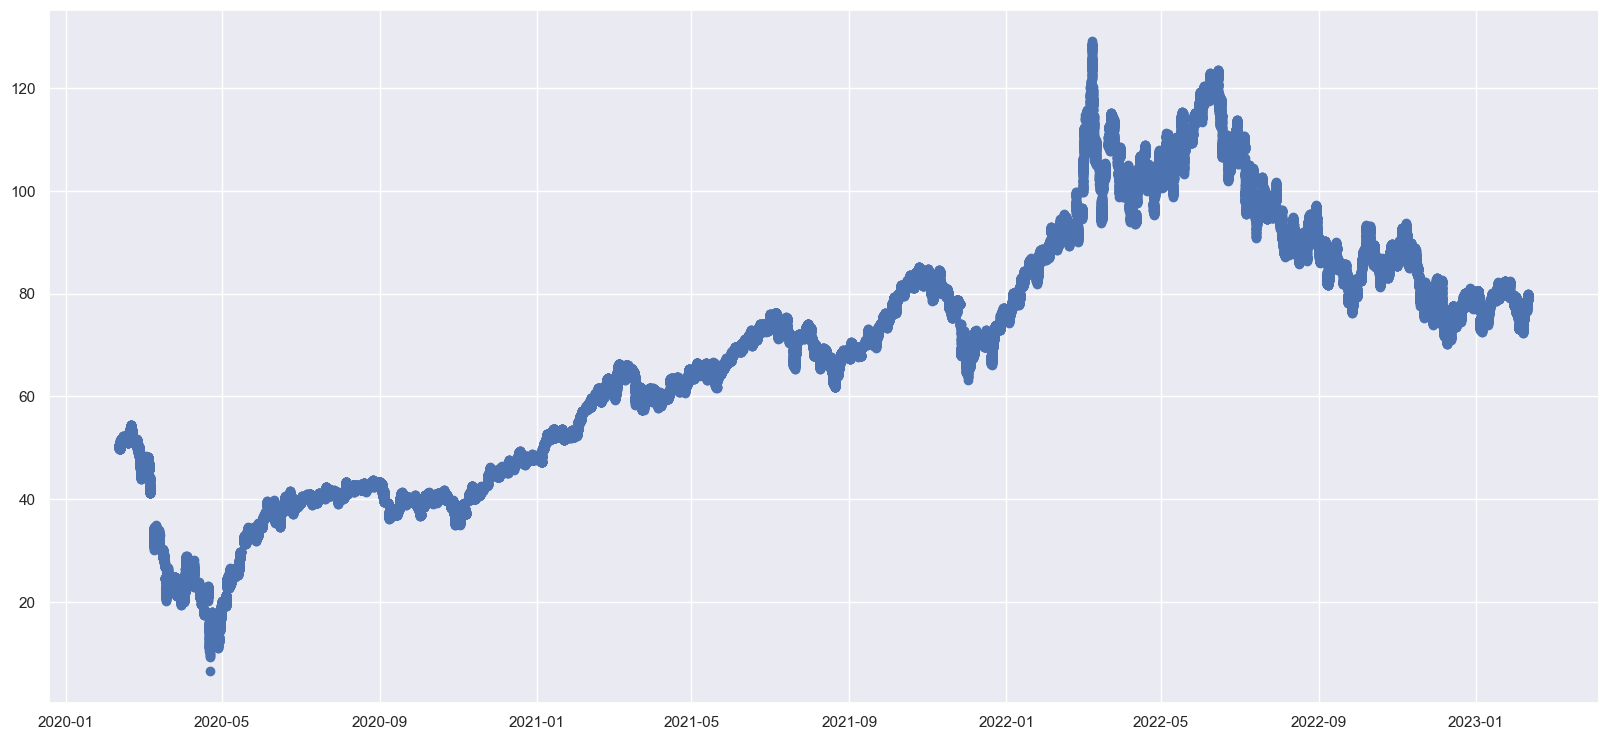

In [103]:
plt.subplots(figsize=(20,9))
plt.scatter(df.index, df['Close_fut'])

# Splitting approach
- Here I try just splitting the data into an initial chunk for training and a later testings set

In [127]:
price_df = df[["Close_fut","Close_gas","Close_btc","Close_bond"]]

In [128]:
price_df.groupby(price_df.index.date).size().unique()

array([107], dtype=int64)

In [141]:
columns = ['Close_fut','Close_gas','Close_btc','Close_bond']
# There are 107 oberservations in each day
# so we can create rolling windows for the past day, five days and 30 days
for frequency in [107, 107 * 5, 107 * 30]:
    for col in columns:
        price_df[str(frequency)+"_std_"+col] = np.log( price_df[col] / price_df[col].shift(1) ).rolling(window=frequency).std()

In [144]:
# code from https://gist.github.com/linuskohl/690da335a34ebf1cfc5ab27973e16ee5
def LeeMykland(S, sampling, significance_level=0.01):
    """
    "Jumps in Equilibrium Prices and Market Microstructure Noise"
    - by Suzanne S. Lee and Per A. Mykland
    
    "https://galton.uchicago.edu/~mykland/paperlinks/LeeMykland-2535.pdf"
    
    Args:
        S (list(float)): An array containing prices, where each entry 
                         corresponds to the price sampled every 'sampling' minutes.
        sampling (int): Minutes between entries in S
        significance_level (float): Defaults to 1% (0.001)
        
    Returns:
        A pandas dataframe containing a row covering the interval 
        [t_i, t_i+sampling] containing the following values:
        J:   Binary value is jump with direction (sign)
        L:   L statistics
        T:   Test statistics
        sig: Volatility estimate
    """
    tm = 252*24*60 # Trading minutes
    k   = ceil(sqrt(tm/sampling))
    r = np.append(np.nan, np.diff(np.log(S)))
    bpv = np.multiply(np.absolute(r[:]), np.absolute(np.append(np.nan, r[:-1])))
    bpv = np.append(np.nan, bpv[0:-1]).reshape(-1,1) # Realized bipower variation
    sig = np.sqrt(movmean(bpv, k-3, 0)) # Volatility estimate
    L   = r/sig
    n   = np.size(S) # Length of S
    c   = (2/np.pi)**0.5
    Sn  = c*(2*np.log(n))**0.5
    Cn  = (2*np.log(n))**0.5/c - np.log(np.pi*np.log(n))/(2*c*(2*np.log(n))**0.5)
    beta_star   = -np.log(-np.log(1-significance_level)) # Jump threshold
    T   = (abs(L)-Cn)*Sn
    J   = (T > beta_star).astype(float)
    J   = J*np.sign(r) # Add direction
    # First k rows are NaN involved in bipower variation estimation are set to NaN.
    J[0:k] = np.nan
    # Build and retunr result dataframe
    return pd.DataFrame({'L': L,'sig': sig, 'T': T,'J':J})

In [ ]:
LeeMykland(

In [142]:
price_df.dropna(axis=0, how='any', inplace=False)

,Close_fut,Close_gas,Close_btc,Close_bond,107_std_Close_fut,107_std_Close_gas,107_std_Close_btc,107_std_Close_bond,535_std_Close_fut,535_std_Close_gas,535_std_Close_btc,535_std_Close_bond,3210_std_Close_fut,3210_std_Close_gas,3210_std_Close_btc,3210_std_Close_bond
Local time,,,,,,,,,,,,,,,,
2020-03-24 07:05:00,23.736,1.6452,6655,178.011,0.008140,0.004927,0.007510,0.001940,0.009565,0.004649,0.007901,0.002347,0.007835,0.003947,0.008186,0.001937
2020-03-24 07:10:00,23.846,1.6364,6644,178.031,0.008091,0.004956,0.007351,0.001912,0.009565,0.004653,0.007898,0.002346,0.007835,0.003948,0.008186,0.001937
2020-03-24 07:15:00,23.835,1.6363,6558,178.058,0.008021,0.004956,0.006850,0.001890,0.009565,0.004651,0.007919,0.002346,0.007835,0.003948,0.008189,0.001937
2020-03-24 07:20:00,23.946,1.6390,6576,177.839,0.007997,0.004955,0.006838,0.001890,0.009567,0.004651,0.007920,0.002346,0.007836,0.003948,0.008189,0.001937
2020-03-24 07:25:00,23.926,1.6420,6559,177.620,0.007941,0.004957,0.006803,0.001869,0.009566,0.004651,0.007920,0.002347,0.007836,0.003948,0.008189,0.001937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 15:35:00,79.799,2.5718,21531,126.899,0.002335,0.003551,0.001243,0.000620,0.001949,0.004199,0.001821,0.000644,0.002118,0.005861,0.002267,0.000832
2023-02-10 15:40:00,79.779,2.5721,21487,126.899,0.002335,0.003550,0.001243,0.000620,0.001949,0.004198,0.001823,0.000644,0.002118,0.005861,0.002268,0.000832
2023-02-10 15:45:00,79.764,2.5739,21552,126.901,0.002336,0.003548,0.001280,0.000619,0.001949,0.004198,0.001828,0.000644,0.002118,0.005861,0.002268,0.000832


In [105]:
price_df.to_csv("prices.csv", index=False)

In [41]:
X_train = price_df[price_df['Local time'] < '2022-08-01'][["Local time","Close_gas","Close_btc","Close_bond"]]
y_train = price_df[price_df['Local time'] < '2022-08-01'][["Close_fut"]]
X_test = price_df[price_df['Local time'] >= '2022-08-01'][["Local time","Close_gas","Close_btc","Close_bond"]]
y_test = price_df[price_df['Local time'] >= '2022-08-01'][["Close_fut"]]

## Initial Model testing

In [44]:
res = {'RF':None, 'GB':None}
for model in res.keys():
    r = model_selection(model)
    res[model] = r

RF


ValueError: 
All the 80 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\soren\anaconda3\envs\Causality\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\soren\anaconda3\envs\Causality\lib\site-packages\sklearn\ensemble\_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "c:\Users\soren\anaconda3\envs\Causality\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\soren\anaconda3\envs\Causality\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "c:\Users\soren\anaconda3\envs\Causality\lib\site-packages\sklearn\utils\validation.py", line 768, in check_array
    dtype_orig = np.result_type(*dtypes_orig)
  File "<__array_function__ internals>", line 180, in result_type
TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>)
